# Maze Master 2000

### utils.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap

def plot_value_function(value_function, maze):
    mask = np.zeros_like(value_function, dtype=bool)
    mask[maze == 1] = True  # Mask obstacles
    mask[maze == 2] = True  # Mask the trap
    mask[maze == 3] = True  # Mask the goal

    trap_position = tuple(np.array(np.where(maze == 2)).transpose(1,0))
    goal_position = np.where(maze == 3)
    obs_position = tuple(np.array(np.where(maze == 1)).transpose(1,0))

    plt.figure(figsize=(10, 10))
    #cmap = sns.light_palette("green", as_cmap=True)
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
    ax = sns.heatmap(value_function, mask=mask, annot=True, fmt=".1f", cmap=cmap,
                     cbar=False, linewidths=1, linecolor='black')
    ax.add_patch(plt.Rectangle(goal_position[::-1], 1, 1, fill=True, edgecolor='black', facecolor='darkgreen'))
    for t in trap_position:
        ax.add_patch(plt.Rectangle(t[::-1], 1, 1, fill=True, edgecolor='black', facecolor='darkred'))
    for o in obs_position:
        ax.add_patch(plt.Rectangle(o[::-1], 1, 1, fill=True, edgecolor='black', facecolor='gray'))
    ax.set_title("Value Function")
    plt.show()

def plot_policy(value_function, maze):
    policy_arrows = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
    policy_grid = np.full(maze.shape, '', dtype='<U2')
    actions = ['up', 'down', 'left', 'right']

    trap_position = tuple(np.array(np.where(maze == 2)).transpose(1,0))
    goal_position = np.where(maze == 3)
    obs_position = tuple(np.array(np.where(maze == 1)).transpose(1,0))

    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i][j] == 1 or (i, j) == goal_position:
                continue  # Skip obstacles and the goal
            best_action = None
            best_value = float('-inf')
            for action in actions:
                next_i, next_j = i, j
                if action == 'up':
                    next_i -= 1
                elif action == 'down':
                    next_i += 1
                elif action == 'left':
                    next_j -= 1
                elif action == 'right':
                    next_j += 1
                if 0 <= next_i < maze.shape[0] and 0 <= next_j < maze.shape[1]:
                    if value_function[next_i][next_j] > best_value:
                        best_value = value_function[next_i][next_j]
                        best_action = action
            if best_action:
                policy_grid[i][j] = policy_arrows[best_action]

    mask = np.zeros_like(value_function, dtype=bool)
    mask[maze == 1] = True  # Mask obstacles
    mask[maze == 2] = True  # Mask the trap
    mask[maze == 3] = True  # Mask the goal

    plt.figure(figsize=(10, 10))
    #cmap = sns.light_palette("green", as_cmap=True)
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
    ax = sns.heatmap(value_function, mask=mask, annot=policy_grid, fmt="", cmap=cmap,
                     cbar=False, linewidths=1, linecolor='black')
    ax.add_patch(plt.Rectangle(goal_position[::-1], 1, 1, fill=True, edgecolor='black', facecolor='darkgreen'))
    for t in trap_position:
        ax.add_patch(plt.Rectangle(t[::-1], 1, 1, fill=True, edgecolor='black', facecolor='darkred'))
    for o in obs_position:
        ax.add_patch(plt.Rectangle(o[::-1], 1, 1, fill=True, edgecolor='black', facecolor='gray'))
    ax.set_title("Policy Map")
    plt.show()

## 1 Basic Questions


None of the terms below has a direct counterpart in supervised learnig. However; they can be related to some terms related to supervised learning in terms of their functionality.

*   Agent is the decision-maker that learns from the process which makes it analogous to the model in supervised learning

*   Environment is the external system that agent interacts and learns from which can be related to the dataset that is used to train the model in the supervised learning

*   Reward is the feedback that agent gets after making a decision which has a similar functionality to the result the loss function that is used in backpropagation(in neural networks) to train the model.

*   Policy is the mapping from states to the actions which can be loosely related to the decision boundaries of supervised learning

*   Exploration is the learning process in which the agent developing the best strategy by taking actions. In supervised learnig this can be loosely related to the training process in which the model makes decisions on the dataset and gets feedback from the loss function.





## 2 Implementing the Maze

Helper Functions

In [2]:
def tuple_sum(a, b): # Element-wise summation of two tuples
  return tuple(map(sum, zip(a, b)))

def tuple_subtract(a, b):  # Element-wise subtraction of two tuples
  res = tuple(map(lambda i, j: i - j, a, b))
  return res

def tuple_swap(a): # swapping tuple elements
  res = tuple((a[1], a[0]))
  return res

Maze Class

In [3]:
class MazeEnvironment:
  def __init__(self):
    # Define the maze layout, rewards

    self.start_pos = (0,0) # Starting position of the agent
    self.current_pos = self.start_pos
    self.pre_pos1 = None
    self.pre_pos2 = None
    self.pre_pos3 = None
    self.pre_pos4 = None
    self.pre_pos5 = None
    self.state_penalty = -1
    self.trap_penalty = -100
    self.goal_reward = 100

    self.actions = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}  # action space (up, down, left, right)

    self.maze_layout = np.array([ # Maze layout 0:open 1:obstacle 2:trap 3:goal
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 3],
       [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
   ])

  def calculate_reward(self, s_type): # for extracting reqard
    if s_type==0:
      return self.state_penalty
    elif s_type==2:
      return self.trap_penalty
    else:
      return self.goal_reward

  def is_valid(self, pos):
        # Check if position is within the maze bounds and not an obstacle
        return (0 <= pos[0] < self.maze_layout.shape[0]) and (0 <= pos[1] < self.maze_layout.shape[1]) and self.maze_layout[pos[0], pos[1]] != 1

  def reset(self): # resets for next episode
    self.current_pos = self.start_pos
    return self.current_pos

  def step(self, action): # arranges new values of states for a taken action
    opposite = tuple_subtract((0,0), action)
    perp_1 = tuple_swap(action)
    perp_2 = tuple_subtract((0,0), perp_1)
    actions = {0:action, 1:opposite, 2:perp_1, 3:perp_2}

    choices = [0, 1, 2, 3]
    probs = [0.75, 0.05, 0.1, 0.1] # chosen direction, the inverse, left of the direction, right of the direction

    choice = np.random.choice(choices, p=probs)
    new_pos = tuple_sum(self.current_pos, actions[choice])

    if self.is_valid(new_pos):
            self.current_pos = new_pos


    reward = self.calculate_reward(self.maze_layout[self.current_pos])

    return self.current_pos, reward

## 3 Temporal Difference (TD) Learning

In [4]:
class MazeTD0(MazeEnvironment): # Inherited from MazeEnvironment
  def __init__(self, maze, alpha=0.1, gamma=0.95, epsilon=0.2, episodes=5000):
    super().__init__()
    self.maze = maze
    self.alpha = alpha #Learning Rate
    self.gamma = gamma #Discount factor
    self.epsilon = epsilon #Exploration Rate
    self.episodes = episodes
    self.utility = np.zeros_like(maze.maze_layout, dtype=float) # Encourage exploration
    #self.utility = np.ones_like(maze.maze_layout, dtype=float) * 10
    for i in range(11):
      for j in range(11):
        if maze.maze_layout[i][j] == 1:
          self.utility[i][j] = -100
        elif maze.maze_layout[i][j] == 3:
          self.utility[i][j] = 1000


  def choose_action(self, state):
    if np.random.rand() < self.epsilon:  # Exploration
        choice = np.random.choice(list(self.actions.keys()))
        return self.actions[choice]
    else:  # Exploitation
        # Calculate valid actions
        valid_actions = [action for action in self.actions.values() if self.is_valid(tuple(np.array(state) + np.array(action)))]

        # Find the action leading to the highest utility state
        best_action = max(valid_actions, key=lambda a: self.utility[tuple(np.array(state) + np.array(a))])

        #print(valid_actions)
        #print("chosen action: ", best_action)

        return best_action


  def update_utility_value(self, current_state, reward, new_state):
    current_value = self.utility[current_state[0], current_state[1]]
    new_value = self.utility[new_state[0], new_state[1]]

    # TD(0) update formula
    self.utility[current_state[0], current_state[1]] += self.alpha * (reward + self.gamma * new_value - current_value)

  def run_episodes(self):
        for i in range(self.episodes):
            state = self.reset()
            done = False
            step_num = 0
            while not done and step_num < 1000:
            #while not done:
                #print("position: ", self.current_pos)
                #input("Press Enter to continue...")
                action = self.choose_action(state)
                new_state, reward = self.step(action)
                self.update_utility_value(state, reward, new_state)
                state = new_state

                if reward == self.goal_reward or reward == self.trap_penalty:  # Episode ends
                    done = True
                step_num += 1
            #self.value_history.append(self.utility.copy())
            if i%100 == 0:
              print("episode: ", i, " is completed.")
              values = maze_td0.utility
              new_values = np.trunc(values*10**2)/(10**2)
              print(new_values.astype(np.int32))
        return self.utility


check if working properly

In [11]:
maze = MazeEnvironment()

In [12]:
maze_td0 = MazeTD0(maze, alpha=0.5, gamma=0.95, epsilon=0.5, episodes=5000)
final_values = maze_td0.run_episodes()

episode:  0  is completed.
[[   0 -100 -100 -100 -100 -100 -100    0    0 -100 -100]
 [   0    0    0    0 -100 -100  -51    0    0    0 -100]
 [  -1 -100 -100    0    0   -1   -2 -100    0 -100 -100]
 [   0 -100 -100    0 -100 -100 -100 -100    0    0    0]
 [   0    0 -100   -1   -1    0 -100 -100    0 -100    0]
 [   0 -100 -100 -100 -100    0    0 -100    0 -100 1000]
 [   0    0    0    0    0    0 -100    0    0    0 -100]
 [-100    0 -100    0 -100    0    0    0 -100 -100    0]
 [-100    0 -100 -100 -100 -100 -100    0    0 -100    0]
 [-100    0    0    0    0 -100 -100 -100    0 -100    0]
 [-100 -100 -100 -100    0    0    0    0    0    0    0]]
episode:  100  is completed.
[[  -8 -100 -100 -100 -100 -100 -100  -50    4 -100 -100]
 [  -5   -9  -17  -19 -100 -100  -87    0  100    9 -100]
 [  -1 -100 -100  -20  -20  -21  -38 -100  354 -100 -100]
 [   4 -100 -100  -20 -100 -100 -100 -100  643  820  931]
 [   5   -1 -100  -20  -21  -29 -100 -100  664 -100 1034]
 [   6 -100 -10

## 4 Q Learning

In [15]:
class MazeQLearning(MazeEnvironment):
    def __init__(self, maze, alpha=0.1, gamma=0.95, epsilon=0.2, episodes=100):
        super().__init__()
        self.maze = maze
        self.alpha = alpha # Learning Rate
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Exploration Rate
        self.episodes = episodes
        # Initialize Q-table with zeros
        self.q_table = np.zeros(self.maze.maze_layout.shape + (len(self.actions),))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:  # Exploration
            return np.random.choice(list(self.actions.keys()))
        else:  # Exploitation
            state_q_values = self.q_table[state[0], state[1], :]
            return np.argmax(state_q_values)

    def update_q_table(self, action, current_state, reward, new_state):
        current_q = self.q_table[current_state[0], current_state[1], action]
        max_future_q = np.max(self.q_table[new_state[0], new_state[1], :])
        new_q = current_q + self.alpha * (reward + self.gamma * max_future_q - current_q)
        self.q_table[current_state[0], current_state[1], action] = new_q

    def run_episodes(self):
        for i in range(self.episodes):
            state = self.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                new_state, reward = self.step(self.actions[action])
                self.update_q_table(action, state, reward, new_state)
                state = new_state

                if reward == self.goal_reward or reward == self.trap_penalty:  # Episode ends
                    done = True

            if i % 100 == 0:
                print(f"Episode {i} completed.")

        return self.q_table

In [36]:
maze = MazeEnvironment()

In [37]:
maze_q = MazeQLearning(maze, alpha=0.5, gamma=0.95, epsilon=0.2, episodes=1000)
final_values = maze_q.run_episodes()

Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.


## 5 Experimental Work

Q-learning

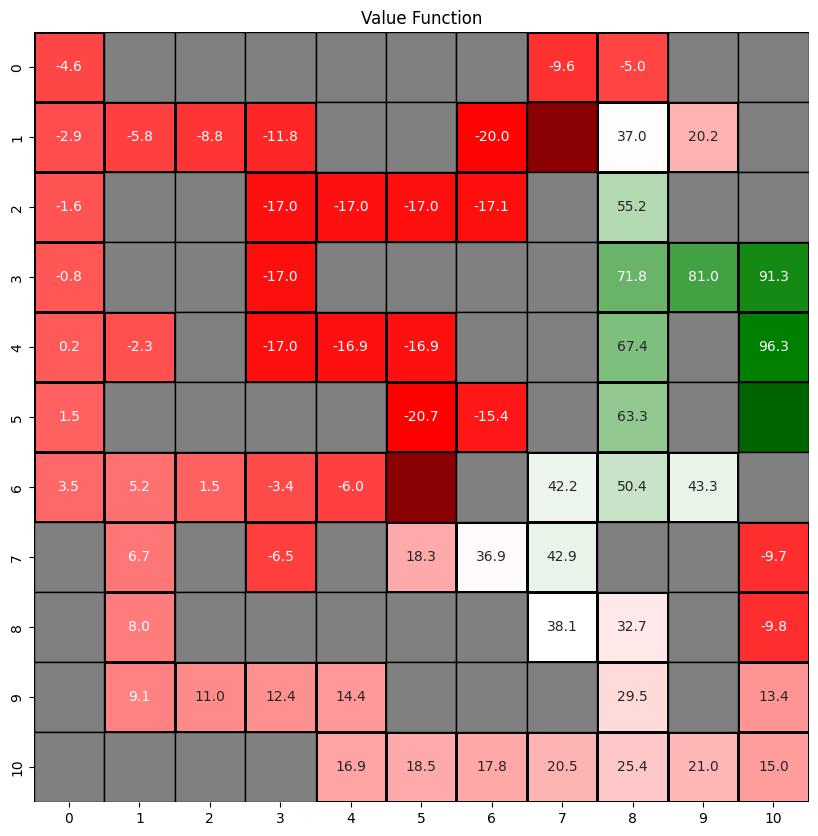

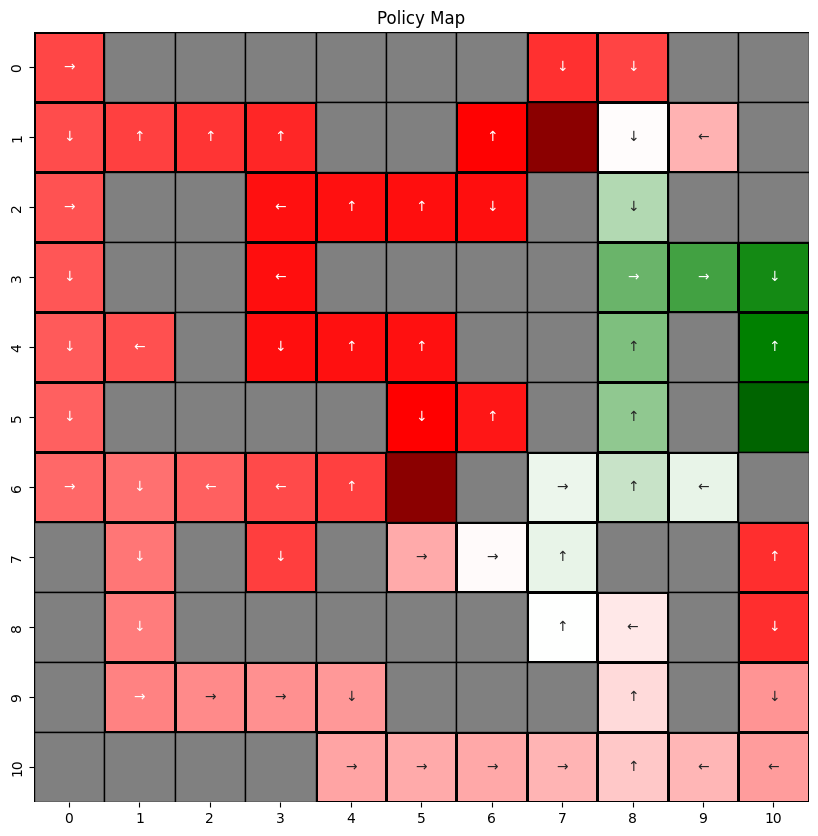

AttributeError: 'MazeQLearning' object has no attribute 'plot_convergence'

In [38]:
# Extract the value function from the Q-table
value_function = np.max(final_values, axis=2)

# Plot the value function
plot_value_function(value_function, maze.maze_layout)
plot_policy(value_function, maze.maze_layout)
maze_q.plot_convergence()

TD-learning

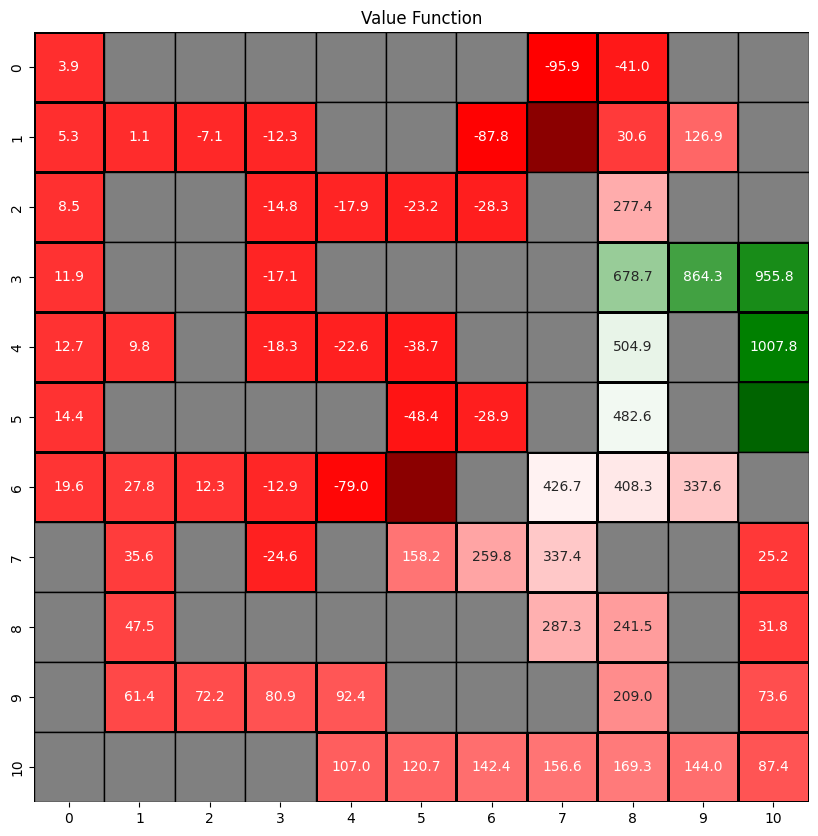

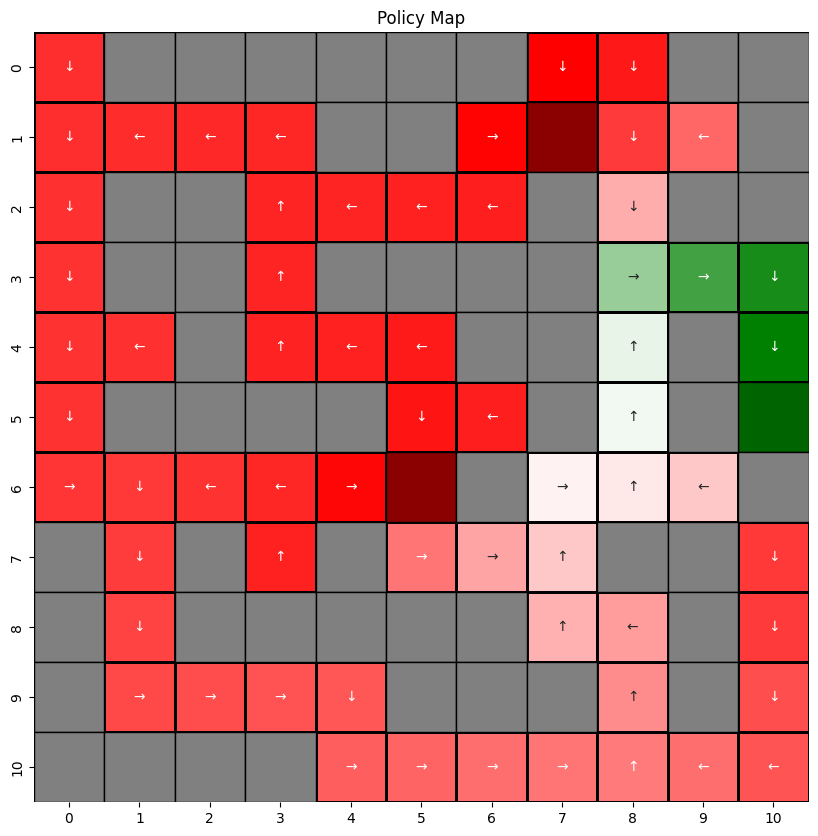

In [13]:
values = maze_td0.utility
plot_value_function(values, maze.maze_layout)
plot_policy(values, maze.maze_layout)

# Playground

In [ ]:
maze_layout = np.array([
       [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 3],
       [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
   ])

actions = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

print(list(actions.values()))

[(-1, 0), (1, 0), (0, -1), (0, 1)]


In [ ]:
i = 0
print(i)

i += 1

input("Press Enter to continue...")

print(i)

0
Press Enter to continue...
1
